# Time Series Prediction

Due to the sequential charasteristics of RNNs, they can be used for time series prediction task. A time series is a series of data points indexed in time order. One example of time series is stock prices at regular intervals of time (hourly, daily, etc.). There have been many attempts to forecast stocks market, some belive predicting the market is impossible because of its total random behaviour, while some (mainly stocks technical analysts) belive not 100% accurate, but it is partly predictable, as they say "history repeats itself" (this phrase indicates that there might be some repetitive patterns in market's behaviour). 

In this practice, we are going to discover ourselves whether it is possible or not, whether we are going to be rich or broke :)  

## Stocks Prediction Using LSTM

LSTMs can be used for modeling time series (such as stocks market) as they are capable of remembering past information. Stock price prediction is similar to any other machine learning problem where we are given a set of features and we have to predict a corresponding value, in this case our features are the closing prices of stocks in the past 60 days and we want to predict next closing price. We can use LSTM to model this 60 days sequence by a hidden state as we do in all other sequence modeling problems:

<p align="center"><img src="https://drive.google.com/thumbnail?id=1hml7fG9_GKDLH1068Wq_Jk-D09FtQk17&sz=w1000-h1000" width="800"/></p>

</br>

We are going to solve these two following problems:
* 1 . Predicting the exact price at time $T_i$ given prices at times $T_{i-60}$, ..., $T_{i-1}$

* 2 . A simplified version of previous problem, predicting the direction of price at time $T_i$ (whether it is increasing or decreasing) given prices at times $T_{i-60}$, ..., $T_{i-1}$


So the first task is a regression and the second one is a classification problem.


### 1. Predicting The Exact Price

**DATA:**

The data that we are going to use are from ***Yahoo Finance*** (a place to look up stock market data and company news). We can accsess historical market data from *Yahoo Finance* using python ***yfinance*** module. 

Let's install *yfinance* module first:

In [2]:
from IPython.display import clear_output

!pip install yfinance

clear_output()

For training our algorithm, we will be using the Apple stock prices from 1st January 2014 to 1st January 2018. In order to evaluate the performance of the algorithm, we will be using the prices from 1st January 2018 to 1st January 2019. 

Let's get the data and visualise it:

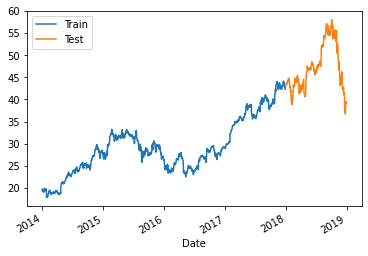

In [3]:

import matplotlib.pyplot as plt
import yfinance as yf  

train_data = yf.download('AAPL','2014-01-01','2018-01-01')
test_data = yf.download('AAPL','2018-01-01','2019-01-01')
plt.figure(facecolor='w')
train_data.Close.plot()
test_data.Close.plot()
plt.legend (["Train", "Test"])

clear_output()
plt.show()

As you can see our data is just a sequence of numbers ordered by time. 

In order to normalize our data we scale them between 0 and 1: 

In [4]:
from sklearn.preprocessing import MinMaxScaler 
import numpy as np
scaler = MinMaxScaler(feature_range = (0, 1)).fit(train_data.Close.values.reshape(-1, 1))

train_scaled = scaler.transform(train_data.Close.values.reshape(-1, 1))
test_scaled = scaler.transform(test_data.Close.values.reshape(-1, 1))  

print ("train_scaled.shape :", train_scaled.shape)
print ("test_scaled.shape :", test_scaled.shape)

train_scaled.shape : (1007, 1)
test_scaled.shape : (251, 1)


Now we create our input output pairs from our sequence:

In [5]:
train_features_set = []  
train_labels = []  
for i in range(60, train_scaled.shape[0]):  
    train_features_set.append(train_scaled[i-60:i, 0])
    train_labels.append(train_scaled[i, 0])

We need to convert these lists to the numpy arrays before we can use them for training. Then in order to train LSTM on our data, we need to convert our data into the shape accepted by the LSTM. We need to convert our data into three-dimensional format. The first dimension is the number of records or rows in the dataset which is 1007 in our case. The second dimension is the number of time steps which is 60 while the last dimension is the number of indicators. Since we are only using one feature, i.e Closing price, the number of indicators will be one.

In [6]:
train_features_set, train_labels = np.array(train_features_set), np.array(train_labels)
train_features_set = np.reshape(train_features_set, (train_features_set.shape[0], train_features_set.shape[1], 1))

In [7]:
train_labels.shape

(947,)

Now let's create and train a simple model, our model has a stack of 4 lstm layers and a single output layer: 

In [8]:
from keras.models import Sequential  
from keras.layers import Dense  
from keras.layers import LSTM  
from keras.layers import Dropout  

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_features_set.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=50))  
model.add(Dropout(0.2))

# we have a single output so this layer has 1 unit
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(train_features_set, train_labels, epochs = 100, batch_size = 30)

# clear_output()

Epoch 1/100
32/32 [==============================] - 14s 81ms/step - loss: 0.0346
Epoch 2/100
32/32 [==============================] - 3s 82ms/step - loss: 0.0067
Epoch 3/100
32/32 [==============================] - 2s 74ms/step - loss: 0.0058
Epoch 4/100
32/32 [==============================] - 2s 75ms/step - loss: 0.0059
Epoch 5/100
32/32 [==============================] - 2s 78ms/step - loss: 0.0051
Epoch 6/100
32/32 [==============================] - 2s 72ms/step - loss: 0.0048
Epoch 7/100
32/32 [==============================] - 2s 73ms/step - loss: 0.0052
Epoch 8/100
32/32 [==============================] - 2s 72ms/step - loss: 0.0045
Epoch 9/100
32/32 [==============================] - 2s 75ms/step - loss: 0.0046
Epoch 10/100
32/32 [==============================] - 2s 75ms/step - loss: 0.0048
Epoch 11/100
32/32 [==============================] - 2s 72ms/step - loss: 0.0041
Epoch 12/100
32/32 [==============================] - 3s 91ms/step - loss: 0.0055
Epoch 13/100
32/32 [====

Now we create our test features set similar to what we did with our training set:

In [9]:
test_scaled = scaler.transform(test_data.Close.values.reshape(-1, 1))  

test_features_set = []  
for i in range(60, test_scaled.shape[0]):  
    test_features_set.append(test_scaled[i-60:i, 0])
    
test_features_set = np.array(test_features_set)  
test_features_set = np.reshape(test_features_set, (test_features_set.shape[0], test_features_set.shape[1], 1))

And finaly let's see the results:

6/6 [==============================] - 2s 31ms/step


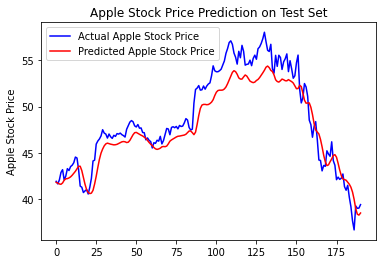

In [10]:
predictions = model.predict(test_features_set)
predictions = scaler.inverse_transform(predictions)  
  
plt.plot(test_data.Close.values[60:], color='blue', label='Actual Apple Stock Price')  
plt.plot(predictions , color='red', label='Predicted Apple Stock Price')  
plt.title('Apple Stock Price Prediction on Test Set')    
plt.ylabel('Apple Stock Price')  
plt.legend()  
plt.show()

$\color{red}{\text{At first, I think that there are some issues with the general idea: for example, the min-max scalar might not be a good idea for price forecasting }}$
$\color{red}{\text{because generally there is no exact maximum price while the trend of the price is usually increasing. }}$
$\color{red}{\text{Secondly, there are many other factors affecting the prices such as the price of other stocks of some other economical indexes such as GDP, }}$
$\color{red}{\text{so it might be a good idea to use a multi input network. }}$

### 2. Predicting The Direction

Previous model can be evaluated  just visually. We can evaluate a classification task using its special measures (such as f-score or accuracy) much better than a regression task. So in order to finaly decide whether the stocks market prediction is practical or not, we define this second task.

Implement a model similar to previous one, this time the task is to predict whether the price is going to increase or decrease (output will be either 1 or 0 respectively) at time $T_i$ given prices at times $T_{i-60}$, ..., $T_{i-1}$ :

#### Data preprocessing

In [12]:
train_data['increase']=1
for i in range(len(train_data)):
    if i>0:
        if train_data['Close'][i]>train_data['Close'][i-1]:
            train_data.iloc[i,-1]=1
        else:
            train_data.iloc[i,-1]=0

test_data['increase']=1
for i in range(len(test_data)):
    if i>0:
        if test_data['Close'][i]>test_data['Close'][i-1]:
            test_data.iloc[i,-1]=1
        else:
            test_data.iloc[i,-1]=0

Adding a new binary term indicating whether the price is increasing or not with respect to the previous step

In [13]:
train_data.head(3)
test_data.head(3)

,Open,High,Low,Close,Adj Close,Volume,increase
Date,,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.950497,102223600,1
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.943356,118071600,0
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.133545,89738400,1


preparing data for learning process:

In [14]:
train2_labels2=train_data.increase.values
train_labels2 = []  
for i in range(60, train_scaled.shape[0]):  
    train_labels2.append(train2_labels2[i])
train_labels2=np.array(train_labels2)

Changing the loss function to binary BinaryCrossentropy

In [15]:
model2 = Sequential()
model2.add(LSTM(units=50, return_sequences=True, input_shape=(train_features_set.shape[1], 1)))
model2.add(Dropout(0.2))

model2.add(LSTM(units=50, return_sequences=True))  
model2.add(Dropout(0.2))

model2.add(LSTM(units=50, return_sequences=True))  
model2.add(Dropout(0.2))

model2.add(LSTM(units=50))  
model2.add(Dropout(0.2))

# we have a single output so this layer has 1 unit
model2.add(Dense(units = 1))
#Changing the loss function to binary BinaryCrossentropy
model2.compile(optimizer = 'adam', loss = 'BinaryCrossentropy')

model2.fit(train_features_set, train_labels2, epochs = 100, batch_size = 30)

Epoch 1/100
32/32 [==============================] - 12s 92ms/step - loss: 1.0232
Epoch 2/100
32/32 [==============================] - 3s 82ms/step - loss: 0.7561
Epoch 3/100
32/32 [==============================] - 2s 77ms/step - loss: 0.7458
Epoch 4/100
32/32 [==============================] - 2s 77ms/step - loss: 0.7340
Epoch 5/100
32/32 [==============================] - 3s 84ms/step - loss: 0.7302
Epoch 6/100
32/32 [==============================] - 3s 84ms/step - loss: 0.7261
Epoch 7/100
32/32 [==============================] - 3s 80ms/step - loss: 0.7074
Epoch 8/100
32/32 [==============================] - 3s 81ms/step - loss: 0.7143
Epoch 9/100
32/32 [==============================] - 3s 83ms/step - loss: 0.7065
Epoch 10/100
32/32 [==============================] - 3s 89ms/step - loss: 0.6984
Epoch 11/100
32/32 [==============================] - 3s 88ms/step - loss: 0.7055
Epoch 12/100
32/32 [==============================] - 2s 77ms/step - loss: 0.7002
Epoch 13/100
32/32 [====

Evaluate your trained model using the test set and report accuracy and f1-score your model archived: 

prediction phase:

In [16]:
test2_labels2=test_data.increase.values
test_labels2 = []  
for i in range(60, test_scaled.shape[0]):  
    test_labels2.append(test2_labels2[i])
test_labels2=np.array(test_labels2)

In [17]:
predictions2 = model2.predict(test_features_set)

6/6 [==============================] - 2s 30ms/step


Creating a thershold of 0.5 to split the 'increasing' from 'decreasing' predictions

In [20]:
pred=[]
for i in predictions2:
    if i>0.5:
        j=1
    else:
        j=0
    pred.append(j)
pred=np.array(pred)

In [96]:
pred.shape

(191,)

In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels2, pred)

array([[  0,  89],
       [  0, 102]], dtype=int64)

### f1 Score

In [27]:
from sklearn.metrics import f1_score
f1_score(test_labels2, pred)

0.6962457337883959

Do not worry if your results are not as promising as before :))
* Comparing new results with previuos ones, why do you think this happens? Doesn't this task supposed to be an easier version of the previous one (if you are able to predict the actual price, you are already able to predict the direction of price trend)? Explain your toughts:


$\color{red}{\text{The stocks price time series has a myriad of oscillations and in the case of predicting the direction of the trend our model is highly sensitive to these oscillations (a small oscillation might cause a set of meaningless 0 or 1 while in the previous case our model is supposed to be near the main trend which leads to a less sensitive case to the oscillations)}}$

* Intuitively explain what kind of properties do you think a time series need to have in order to be predictable? 

$\color{red}{\text{Any learnable predictive model consists of a set of mathematical equations in order to find the underlying relationship between the inputs and the target values}}$
$\color{red}{\text{To find highly nonlinear relationships consequently, more comprehensive databases are required}}$
$\color{red}{\text{Moreover, time series with fewer oscillations and more interpretable relations for the predictive machine (for example linear relations for regression model) }}$
$\color{red}{\text{will lead to more promising predictions}}$
$\color{red}{\text{At last, a time series with repeated patterns is favorable for an RNN model since it carrying information from the past to predict the future}}$
